推荐系统可以大致分为三类：基于内容的推荐系统，基于协同过滤推荐系统和混合推荐系统（使用这两者方式组合）。

基于内容的推荐系统使用物品的特征来推荐其他类似物品。 例如，如果我在淘宝上浏览一件纯色T恤，基于内容的推荐系统可能会推荐给我其他款式的纯色的T恤，因为它们具有相似的特征（袖子，颜色等）。

基于协同过滤的系统根据用户的行为来推荐其他物品。 它们包括基于用户协同过滤(userCF)，和基于物品的协同过滤(ItemCF)两类。 userCF的基本思想是同寻找相似用户,并推荐相似用户喜好的物品,如：

 俗话说“物以类聚、人以群分”，拿看电影这个例子来说，如果你喜欢《蝙蝠侠》、《碟中谍》、《星际穿越》、《源代码》等电影，另外有个人也都喜欢这些电影，而且他还喜欢《钢铁侠》，则很有可能你也喜欢《钢铁侠》这部电影。

所以说，当一个用户 A 需要个性化推荐时，可以先找到和他兴趣相似的用户群体 G，然后把 G 喜欢的、并且 A 没有听说过的物品推荐给 A，这就是基于用户的协同过滤算法。

ItemCF的核心思想是给用户推荐那些和他们之前喜欢的物品相似的其他物品，如:

比如，用户A之前买过《数据挖掘导论》，该ItemCF会根据此行为给你推荐《机器学习》，但是ItemCF算法并不利用物品的内容属性计算物品之间的相似度，它主要通过分析用户的行为记录计算物品之间的相似度。

在此文中，我们将构建一个基于物品的协同过滤系统(ItemCF)。

# 数据分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
movies = pd.read_csv( './data/douban/movies.csv')
print('电影数目（有名称）：%d' % movies[~pd.isnull(movies.title)].shape[0])
print('电影数目（没有名称）：%d' % movies[pd.isnull(movies.title)].shape[0])
print('电影数目（总计）：%d' % movies.shape[0])
movies.sample(10)

电影数目（有名称）：33258
电影数目（没有名称）：24166
电影数目（总计）：57424


,movieId,title
37436,37436,Le Portrait mystérieux
51467,51467,NaN
56089,56089,NaN
209,209,NaN
30578,30578,过埠新娘
11748,11748,Jour se lève
45952,45952,The Giraffe
24152,24152,NaN
57278,57278,NaN
30354,30354,NaN


In [2]:
ratings = pd.read_csv('./data/douban/ratings.csv')
print('用户数据：%d' % ratings.userId.unique().shape[0])
print('电影数据：%d' % ratings.movieId.unique().shape[0])
print('评分数目：%d' % ratings.shape[0])
ratings.head()

用户数据：28718
电影数据：57424
评分数目：2828500


,userId,movieId,rating,timestamp
0,0,0,5,1318222486
1,0,1,4,1313813583
2,0,2,5,1313458035
3,0,3,5,1313327802
4,0,4,3,1312126734


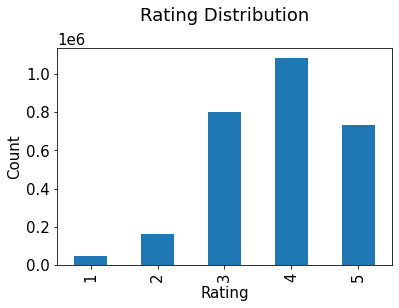

In [3]:
# 查看一下ratings表中的rating字段的数据分布
plt.rc("font", size=15)
ratings.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [4]:
# 接下来我们查看一下评分次数最多的电影。
rating_count = pd.DataFrame(ratings.groupby('movieId')['rating'].count())
rating_count.sort_values('rating', ascending=False).head()

,rating
movieId,
150,6574
415,6003
414,5994
19,5274
93,5072


In [5]:
# 查看这些评分最多的电影
most_rated_movies = pd.DataFrame([150, 415, 414, 19, 93], index=np.arange(5), columns = ['movieId'])
most_rated_movies_summary = pd.merge(most_rated_movies, movies, on='movieId')
most_rated_movies_summary

,movieId,title
0,150,The Shawshank Redemption
1,415,Léon
2,414,Forrest Gump
3,19,Inception
4,93,Le fabuleux destin d\'Amélie Poulain


 这些电影名称都不是中文名，通过查询豆瓣电影网，查询到了它们的中文名称：

The Shawshank Redemption：肖申克的救赎<br/>
Léon:这个杀手不太冷<br/>
Forrest Gump:阿甘正传<br/>
Inception:盗梦空间<br/>
Le fabuleux destin d\'Amélie Poulain:天使爱美丽 <br/>

这几部电影在豆瓣电影网上的确都是高分电影。

In [7]:
# 查看一下每部电影的平均得分和它们的评分次数
average_rating = pd.DataFrame(ratings.groupby("movieId")["rating"].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('movieId')['rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,rating,ratingCount
movieId,,
150,4.747642,6574
415,4.678161,6003
414,4.662829,5994
19,4.591771,5274
93,4.523265,5072


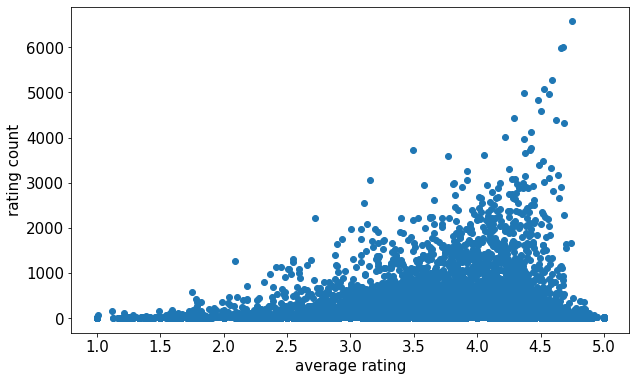

In [11]:
# 每部电影的平均得分和评分次数的分布情况
plt.figure(figsize=(10,6))
plt.scatter(average_rating.rating,average_rating.ratingCount)

plt.xlabel('average rating')
plt.ylabel('rating count')
plt.show()

从散点图上可以看到 电影的平均得分和评分次数呈现正相关趋势。电影平均得分越高,评分次数也越高。

# 数据清洗

我们现在要构造一个用户对电影的评分矩阵,该矩阵每一行代表一个user，每一列代表一部movie，矩阵中的每一个值代表某位用户对某部电影的评分。但是由于用户总数为28718，电影总数为57424，那么该矩阵的维度将达到(28718,57424),这将是一个超大矩阵,为了减少计算的复杂度,必须要减小数据的维度,以免出现内存溢出的情况.

我们要过滤掉一部分评分数据,那么过滤的依据是什么?我个人觉得可以从两个方面来考虑：

第一、我们针对用户来过滤:凡是用户评分次数少于10次的评分数据

第二、我们针对电影来过滤:凡是电影被评分的次数少于10次的评分数据

以上两点是我个人的想法，具体是10次还是多少次可以根据实际情况来确定。


In [14]:
user_rating_count = ratings['userId'].value_counts()
ratings = ratings[ratings['userId'].isin(user_rating_count[user_rating_count >= 10].index)]
 
movied_rating_counts = ratings['movieId'].value_counts()
ratings = ratings[ratings['movieId'].isin(movied_rating_counts[movied_rating_counts >= 10].index)]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2680328 entries, 0 to 2828499
Data columns (total 4 columns):
 #   Column     Dtype
---  ------     -----
 0   userId     int64
 1   movieId    int64
 2   rating     int64
 3   timestamp  int64
dtypes: int64(4)
memory usage: 102.2 MB


In [15]:
# 删除之后，恢复索引
ratings.index=range(ratings.shape[0])
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680328 entries, 0 to 2680327
Data columns (total 4 columns):
 #   Column     Dtype
---  ------     -----
 0   userId     int64
 1   movieId    int64
 2   rating     int64
 3   timestamp  int64
dtypes: int64(4)
memory usage: 81.8 MB


# 电影推荐

In [16]:
ratings_pivot = ratings.pivot(index='userId', columns='movieId',values='rating').fillna(0)
userID = ratings_pivot.index
movieId = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

MemoryError: Unable to allocate 2.65 GiB for an array with shape (18304, 19452) and data type float64

好了，我们构造了用户对电影的评分矩阵，该矩阵的维度为(18378,19454) 比原来小了很多，矩阵中有很多0元素表示该用户没有看过该部电影，接下来我们计算皮尔森相关系数的方式，来寻找最相似的电影，假设我要寻找movieId为2550(黃飛鴻之三獅王爭霸)的这部电影的相似电影

In [ ]:
example_movieId=2550
bones_ratings = ratings_pivot[example_movieId]
similar_to_bones = ratings_pivot.corrwith(bones_ratings)
 
corr_bones = pd.DataFrame(similar_to_bones, columns=['pearsonR'])
corr_bones.dropna(inplace=True)
corr_summary = corr_bones.join(average_rating['ratingCount'])
pearson_corr=corr_summary[corr_summary['ratingCount']>=500].sort_values('pearsonR', ascending=False).head(11)
print(movies[movies.movieId == example_movieId]['title'].values[0])
print(pearson_corr)

我们在计算皮尔森相关系数的时候,还有一个重要因素需要考虑,那就是用户的评分次数，评分次数越多,评价结果就越准确,因此我们还要设定一个评分次数的阈值，这里暂定为500次。以上结果为与"黃飛鴻之三獅王爭霸"最相似的10部电影，其中包含了的皮尔森相关系数(从大到小进行了排序)和评价次数

In [ ]:
# 查看这10部电影的名称
print(movies[movies.movieId == example_movieId]['title'].values[0])
corr_movie_ids=pearson_corr.index
movie_corr = pd.DataFrame(corr_movie_ids[1:], index=np.arange(10), columns=['movieId'])
corr_movies = pd.merge(movie_corr, movies, on='movieId')
corr_movies

从以上的结果看来这10部电影大都为李连杰主演的功夫片,从内容上看与“黃飛鴻之三獅王爭霸”颇为相似。